In [18]:
# Imports 

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12,
                 'axes.spines.right': False,
                 'axes.spines.top': False,
                 'axes.linewidth':1.2,
                 'xtick.major.size': 6,
                 'xtick.major.width': 1.2,
                 'ytick.major.size': 6,
                 'ytick.major.width': 1.2,
                 'legend.frameon': False,
                 'legend.handletextpad': 0.1,
                 'figure.figsize': [10.0, 3.0],
                 'svg.fonttype': 'none',
                 'text.usetex': False})

# 1. Modeling a neuron with NMDA/AMPA conductance-based synapses


<img src="images/Neuromorphic_circuit_diagram7.png" width="500">

In [4]:
def syn_driving_force(V):
    E_rev = 0          # (mV) Reversal potential
    E_ampa = E_rev - V # (mV) Driving force
    return E_ampa   

def ampa_current(E_ampa, g_ampa=1):
    '''
    E_nmda: driving force (mV)
    g_nmda: conductance (nS)
    mgblock: unitless
    '''
    i_ampa = E_ampa * g_ampa # AMPA current in pA
    i_ampa *= 1e-3 # convert to nA
    return i_ampa  

def nmda_sigmoid(V):
    '''
    V: postsynaptic voltage (mV)
    '''
    mg = 1.       # (mM) external magnesium concentration 
    vshift = -0   # (mV) shifts the mg unblock
    Kd = 9.98     # (mM) modulate Mg concentration-dependence
    gamma = 0.101 # (/mV) modulate slope of Mg sensitivity
    E_rev = 0.    # (mV) reversal potentital of NMDA channel  
    
    mgblock = 1 / (1 + np.exp(gamma * -(V-vshift)) * (mg / Kd)) # sigmoid voltage-dependent channel unblocking
    return mgblock

def nmda_current(E_nmda, mgblock=1, g_nmda=1):
    '''
    E_nmda: driving force (mV)
    g_nmda: conductance (nS)
    mgblock: unitless
    '''
    i_nmda = E_nmda * g_nmda * mgblock # NMDA current in pA
    i_nmda *= 1e-3 # convert to nA
    return i_nmda   

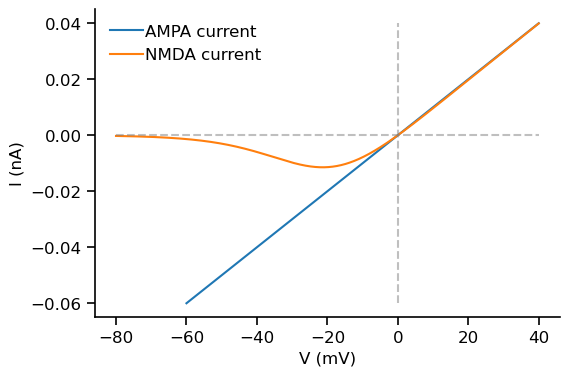

In [5]:
# Plot NMDA properties 

fig,ax = plt.subplots(figsize=[6,4])
v = np.linspace(-60,40,1000)
E_ampa = syn_driving_force(v)
i = ampa_current(E_ampa)
ax.plot(v,-i, label='AMPA current')

v = np.linspace(-80,40,1000)
E_nmda = syn_driving_force(v)
mgblock = nmda_sigmoid(v)
i = nmda_current(E_nmda,mgblock)
ax.plot(v,-i, label='NMDA current')

ax.plot([-80,40],[0,0],'--',color='gray',alpha=0.5)
ax.plot([0,0],[-0.06,0.04],'--',color='gray',alpha=0.5)
ax.set_xlabel('V (mV)')
ax.set_ylabel('I (nA)')
ax.legend()
plt.show()

In [6]:
# Run simulation with time-varying conductance + voltage-dependent driving force 

# Simulation runtime parameters
dt = 0.1  # time step (ms)
T = 300   # simulation time (ms)
time = np.arange(0., T, dt)

def run_simulation(synapse_range, tau_ampa, tau_nmda):
    first_stim_time = 50.  #ms
    delta_stim = 1. #ms
    end_time = 200. #ms
    stim_timesteps = np.arange(first_stim_time, first_stim_time+delta_stim*synapse_range, delta_stim) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors

    # Model parameters
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    E_cell = -70
#     weights = np.random.uniform(0.2,5.,synapse_range)
    weights_ampa = np.ones(synapse_range)*5
    weights_nmda = np.ones(synapse_range)*8
    
    simulation_results = {'single_EPSPs':[np.ones(len(time))*E_cell],
                          'V':[], 'I_total':[], 'I_ampa':[], 'I_nmda':[],
                          'E_syn':[], 'g_ampa':[], 'g_nmda':[]}
    
    # Simulate single EPSPs
    for synapse_id in range(synapse_range):
        V = np.ones(len(time)) * E_cell
        this_stim_time = stim_timesteps[synapse_id]
        g_ampa = weights_ampa[synapse_id]
        g_nmda = weights_nmda[synapse_id]
        for t in range(this_stim_time, len(time)):            
            E_syn = syn_driving_force(V[t])
            I_ampa = g_ampa * E_syn *1e-3 #currents converted from pA to nA
            I_nmda = g_nmda * E_syn * nmda_sigmoid(V[t]) *1e-3 #currents converted from pA to nA
            I = (I_ampa + I_nmda) 
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((E_cell-V[t]) + I*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
                dgdt_ampa = -g_ampa/tau_ampa
                g_ampa += dgdt_ampa * dt
                dgdt_nmda = -g_nmda/tau_nmda
                g_nmda += dgdt_nmda * dt
        simulation_results['single_EPSPs'].append(V)

    # Simulate combined EPSPs
    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        V = np.ones(len(time)) * E_cell
        I = np.zeros(len(time))
        I_ampa = np.zeros(len(time))
        I_nmda = np.zeros(len(time))
        E_syn = np.zeros(len(time))
        g_ampa = np.zeros(len(time))
        g_nmda = np.zeros(len(time))
        
        stim_timesteps_sub = stim_timesteps[0:num_synapses]

        for t in range(len(time)): 
            if t in stim_timesteps_sub:
                active_synapse_ids = np.where(stim_timesteps_sub==t)[0]
                g_ampa[t] += np.sum(weights_ampa[active_synapse_ids])      # nS   
                g_nmda[t] += np.sum(weights_nmda[active_synapse_ids])    # nS                

            E_syn[t] = syn_driving_force(V[t])
            I_ampa[t] = g_ampa[t] * E_syn[t] *1e-3 #currents converted from pA to nA
            I_nmda[t] = g_nmda[t] * E_syn[t] * nmda_sigmoid(V[t]) *1e-3 #currents converted from pA to nA
            I[t] = I_ampa[t] + I_nmda[t]
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((E_cell-V[t]) + I[t]*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt

                dgdt_ampa = -g_ampa[t]/tau_ampa
                g_ampa[t+1] = g_ampa[t] + dgdt_ampa*dt
                dgdt_nmda = -g_nmda[t]/tau_nmda
                g_nmda[t+1] = g_nmda[t] + dgdt_nmda * dt
                
        simulation_results['V'].append(V)
        simulation_results['I_total'].append(I)
        simulation_results['I_ampa'].append(I_ampa)
        simulation_results['I_nmda'].append(I_nmda)
        simulation_results['E_syn'].append(E_syn)
        simulation_results['g_ampa'].append(g_ampa)
        simulation_results['g_nmda'].append(g_nmda)
    simulation_results['stim_times'] = stim_timesteps

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
        
    return simulation_results

synapse_range = 8
simulation_results = run_simulation(synapse_range, tau_ampa=2, tau_nmda=80)

If synaptic driving force is voltage-dependent, the voltage steps get smaller with each successive synapse, 
resulting in strongly sub-linear summation of the individual potentials


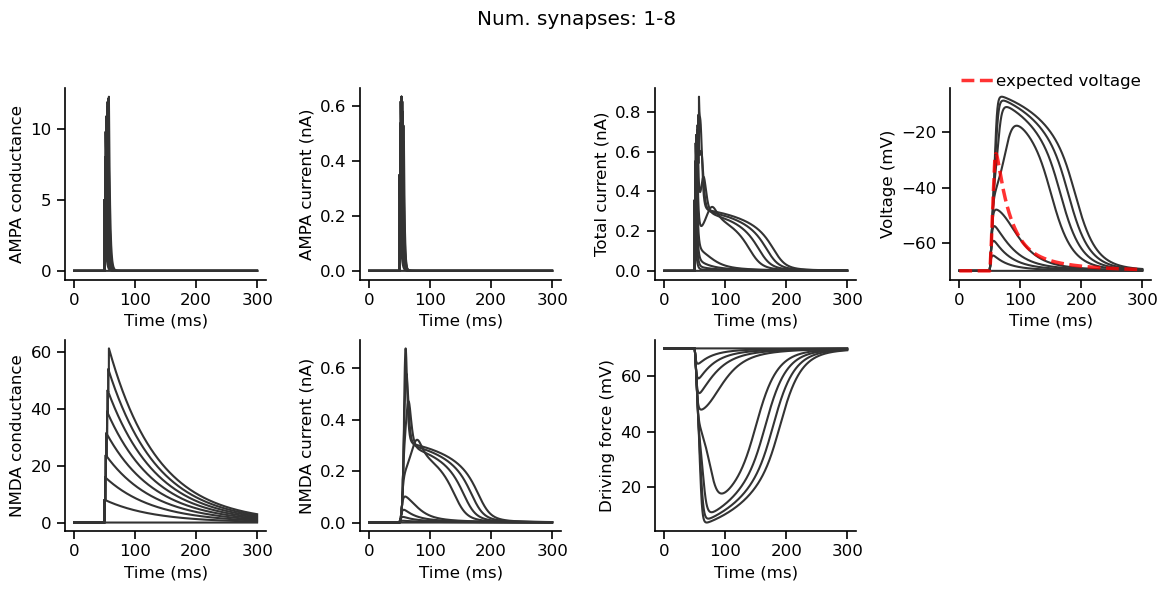

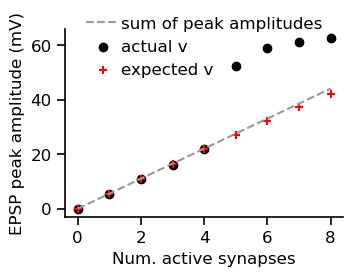

In [7]:
# Plot simulation results 

fig,ax = plt.subplots(2,4,figsize=(12,6))
titles = {'V': 'Voltage (mV)', 'I_total': 'Total current (nA)', 'E_syn': 'Driving force (mV)',
          'I_ampa': 'AMPA current (nA)', 'I_nmda': 'NMDA current (nA)', 
          'g_ampa': 'AMPA conductance',  'g_nmda': 'NMDA conductance'}

line_color = [0.2,0.2,0.2]
ax[0,0].plot(time, simulation_results['g_ampa'], c=line_color)
ax[0,0].set_xlabel('Time (ms)')
ax[0,0].set_ylabel(titles['g_ampa'])

ax[1,0].plot(time, simulation_results['g_nmda'], c=line_color)
ax[1,0].set_xlabel('Time (ms)')
ax[1,0].set_ylabel(titles['g_nmda'])

ax[0,1].plot(time, simulation_results['I_ampa'], c=line_color)
ax[0,1].set_xlabel('Time (ms)')
ax[0,1].set_ylabel(titles['I_ampa'])

ax[1,1].plot(time, simulation_results['I_nmda'], c=line_color)
ax[1,1].set_xlabel('Time (ms)')
ax[1,1].set_ylabel(titles['I_nmda'])

ax[1,2].plot(time, simulation_results['E_syn'], c=line_color)
ax[1,2].set_xlabel('Time (ms)')
ax[1,2].set_ylabel(titles['E_syn'])

ax[0,2].plot(time, simulation_results['I_total'], c=line_color)
ax[0,2].set_xlabel('Time (ms)')
ax[0,2].set_ylabel(titles['I_total'])

ax[0,3].plot(time, simulation_results['V'], c=line_color)
ax[0,3].set_xlabel('Time (ms)')
ax[0,3].set_ylabel(titles['V'])

baselines = simulation_results['single_EPSPs'][0,:]
summed_EPSP_trace = np.sum(simulation_results['single_EPSPs']-baselines,axis=1) + baselines[0]
ax[0,3].plot(time,summed_EPSP_trace,'--',linewidth=2.5,alpha=0.8,color='r', label='expected voltage')
ax[0,3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

ax[1,3].axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')


singleEPSP_amplitudes = np.max(simulation_results['single_EPSPs'],axis=0) - baselines
linear_sum = np.cumsum(singleEPSP_amplitudes)
expected_amplitudes = np.max(np.cumsum(simulation_results['single_EPSPs']-baselines,axis=1),axis=0)
multiEPSP_amplitudes = np.max(simulation_results['V'],axis=0) - baselines
num_EPSPs = len(multiEPSP_amplitudes)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6], label='sum of peak amplitudes')
ax.scatter(np.arange(num_EPSPs), multiEPSP_amplitudes, color='k', label='actual v')
ax.scatter(np.arange(num_EPSPs), expected_amplitudes, marker='+',color='r',label='expected v')
ax.set_ylabel('EPSP peak amplitude (mV)')
ax.set_xlabel('Num. active synapses')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))


plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)

print('If synaptic driving force is voltage-dependent, the voltage steps get smaller with each successive synapse, \nresulting in strongly sub-linear summation of the individual potentials')

plt.show()

# <font color='blue'> 2. Emulating AMPA/NMDA conductance-based synapses in neuromorphic hardware </font>

<img src="images/Neuromorphic_circuit_diagram8.png" width="350">

In [19]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt, temperature=30):
        self.dt = dt
        self.R = 5220
        self.R_history = []
        self.controlI = 0
        self.controlI_history = []
        self.temperature= temperature
        
    def time_step(self):
        self.R_history.append(self.R)
        self.controlI_history.append(self.controlI)

        R_eq = self.transfer_func(self.controlI) 

        if self.R > R_eq:
            rise_tau = np.maximum(self.dt, self.rise_tau(R=self.R, temperature=self.temperature))
            dRdt = (R_eq - self.R) / rise_tau
        else:
            decay_tau = np.maximum(self.dt, self.decay_tau(R=self.R, temperature=self.temperature))
            dRdt = (R_eq - self.R) / decay_tau

        self.R += dRdt * self.dt
        
    def transfer_func(self, controlI):
        '''
        Function to convert between controlI and resistance
        controlI: current in units of mA
        '''        
        R_eq = 5000*np.exp(-0.1*controlI)+220 # (Ohm)
        g_eq  = 1 / R_eq * 1e9 # convert to conductance (nS)
        return R_eq
    
    def inv_transfer_func(self, R):
        controlI = -10*np.log((R-220)/5000)
        return controlI
        
    def decay_tau(self, controlI=None, R=None, temperature=70):
        if controlI is None:
            controlI = self.inv_transfer_func(R)
        tau = (0.44 * controlI**0.5 + 1.45) * np.exp(0.2*(temperature-70))
        tau = tau * 1e3 # convert to ms
        return tau 
    
    def rise_tau(self, R=None, temperature=70):
        tau = 1/(R+200) * np.exp(0.2*(temperature-72))
        tau = tau * 1e3 # convert to ms
        return tau 

#     def compute_controlI(self, tau):
#         controlI = (0.4*self.dt / (tau-self.dt)) - 1e-4
#         return controlI


IndentationError: expected an indented block (2917364547.py, line 50)

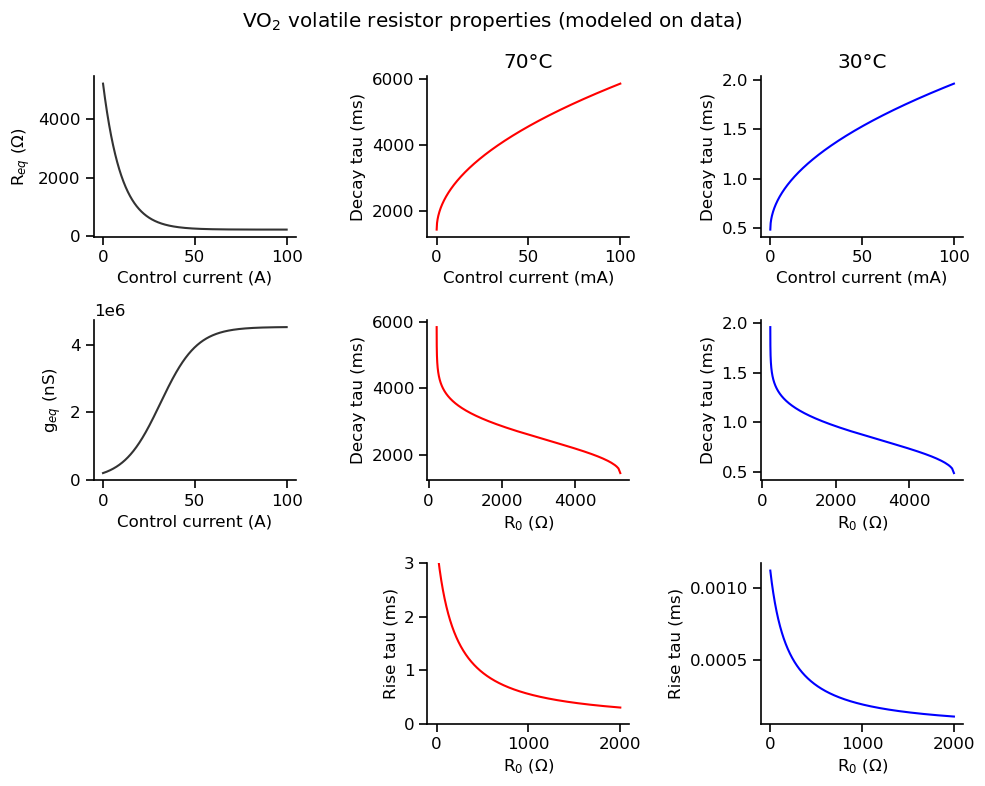

In [20]:
# Plot properties 

# Simulation runtime parameters
dt = 0.1  # time step (ms)
T = 300   # simulation time (ms)
time = np.arange(0., T, dt)

line_color = [0.2,0.2,0.2]
fig,ax = plt.subplots(3,3,figsize=[10,8])
g_volatile = Volatile_Resistor(dt)
controlI = np.linspace(0,100,1000)
R_eq = g_volatile.transfer_func(controlI)
g_eq = 1e9 / R_eq

ax[0,0].plot(controlI,R_eq, c=line_color)
ax[0,0].set_xlabel('Control current (A)')
ax[0,0].set_ylabel('R$_{eq}$ (Ω)')

ax[1,0].plot(controlI,g_eq, c=line_color)
ax[1,0].set_xlabel('Control current (A)')
ax[1,0].set_ylabel('g$_{eq}$ (nS)')

ax[0,1].plot(controlI,g_volatile.decay_tau(controlI=controlI,temperature=70),c='r',label='70°C')
ax[0,1].set_title('70°C')
ax[0,1].set_xlabel('Control current (mA)')
ax[0,1].set_ylabel('Decay tau (ms)')

ax[0,2].plot(controlI,g_volatile.decay_tau(controlI=controlI,temperature=30),c='b',label='30°C')
ax[0,2].set_title('30°C')
ax[0,2].set_xlabel('Control current (mA)')
ax[0,2].set_ylabel('Decay tau (ms)')

ax[1,1].plot(R_eq,g_volatile.decay_tau(R=R_eq,temperature=70),c='r')
ax[1,1].set_xlabel('R$_{0}$ (Ω)')
ax[1,1].set_ylabel('Decay tau (ms)')

ax[1,2].plot(R_eq,g_volatile.decay_tau(R=R_eq,temperature=30),c='b')
ax[1,2].set_xlabel('R$_{0}$ (Ω)')
ax[1,2].set_ylabel('Decay tau (ms)')

ax[2,0].axis('off')
R_range = np.linspace(0,2000,1000)
ax[2,1].plot(R_range,g_volatile.rise_tau(R=R_range,temperature=70),c='r')
ax[2,1].set_xlabel('R$_{0}$ (Ω)')
ax[2,1].set_ylabel('Rise tau (ms)')
ax[2,1].set_ylim([0,3])

R_range = np.linspace(0,2000,1000)
ax[2,2].plot(R_range,g_volatile.rise_tau(R=R_range,temperature=30),c='b')
ax[2,2].set_xlabel('R$_{0}$ (Ω)')
ax[2,2].set_ylabel('Rise tau (ms)')

plt.suptitle('VO$_{2}$ volatile resistor properties (modeled on data)')
plt.tight_layout()
plt.show()

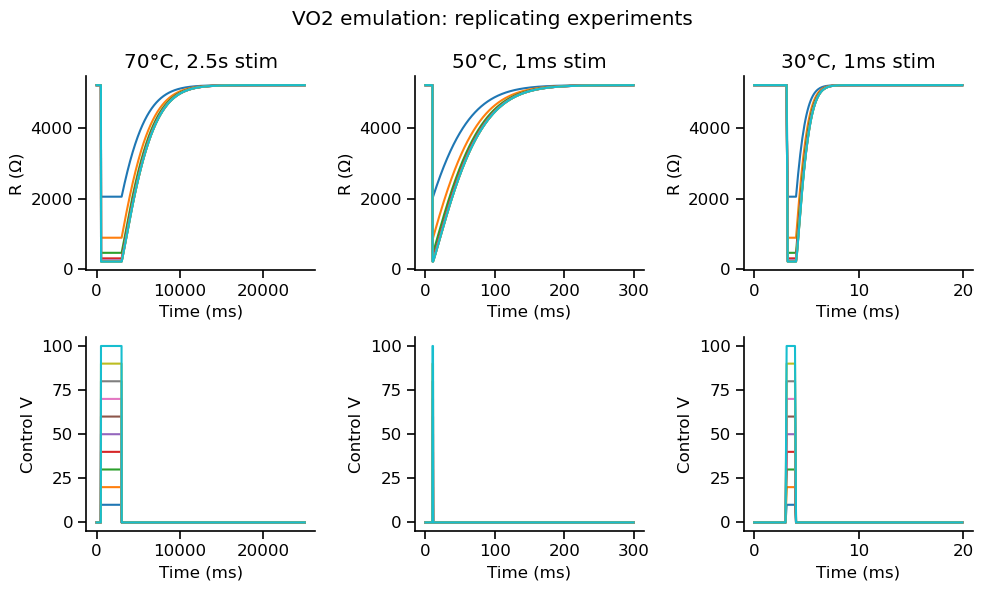

In [24]:
# Plot test pulses: replicating experiments 

# baselineI = g_volatile.compute_controlI(20)
# print(f"Pulse control V = {pulseI}")
# print(f"Baseline control V (to set the decay tau) = {baselineI}")
# print(f"Tau = {round(g_volatile.tau(baselineI))} ms")

def VO2_test_pulse(dt, T, stim_time, temperature):
    '''
    Simulate a test pulse of a VO2 volatile resistor
    :param dt: time step (ms)
    :param T: simulation time (ms)
    '''

    time = np.arange(0., T, dt)

    R_hist_ls = []
    controlI_hist_ls = []
    for pulseI in np.arange(10,110,10):
        g_volatile = Volatile_Resistor(dt, temperature=temperature)
        for t in time:
            if t>stim_time[0] and t<stim_time[1]:
                g_volatile.controlI = pulseI  
            else:
                g_volatile.controlI = 0
            g_volatile.time_step()
        R_hist_ls.append(g_volatile.R_history)
        controlI_hist_ls.append(g_volatile.controlI_history)

    R_hist = np.array(R_hist_ls).T
    controlI_hist = np.array(controlI_hist_ls).T
    return time, R_hist, controlI_hist

fig,ax = plt.subplots(2,3,figsize=[10,6])

time, R_hist, controlI_hist = VO2_test_pulse(dt=10,T=25000, stim_time=(500,3000), temperature=70)
ax[0,0].plot(time, R_hist)
ax[0,0].set_xlabel('Time (ms)')
ax[0,0].set_ylabel('R (Ω)')
ax[0,0].set_title('70°C, 2.5s stim')

ax[1,0].plot(time, controlI_hist)
ax[1,0].set_xlabel('Time (ms)')
ax[1,0].set_ylabel('Control V')

time, R_hist, controlI_hist = VO2_test_pulse(dt=0.1,T=300, stim_time=(10,11), temperature=50)
ax[0,1].plot(time, R_hist)
ax[0,1].set_xlabel('Time (ms)')
ax[0,1].set_ylabel('R (Ω)')
ax[0,1].set_title('50°C, 1ms stim')

ax[1,1].plot(time, controlI_hist)
ax[1,1].set_xlabel('Time (ms)')
ax[1,1].set_ylabel('Control V')

time, R_hist, controlI_hist = VO2_test_pulse(dt=0.1,T=20, stim_time=(3,4), temperature=30)
ax[0,2].plot(time, R_hist)
ax[0,2].set_xlabel('Time (ms)')
ax[0,2].set_ylabel('R (Ω)')
ax[0,2].set_title('30°C, 1ms stim')

ax[1,2].plot(time, controlI_hist)
ax[1,2].set_xlabel('Time (ms)')
ax[1,2].set_ylabel('Control V')

plt.suptitle('VO2 emulation: replicating experiments')

plt.tight_layout()
plt.show()

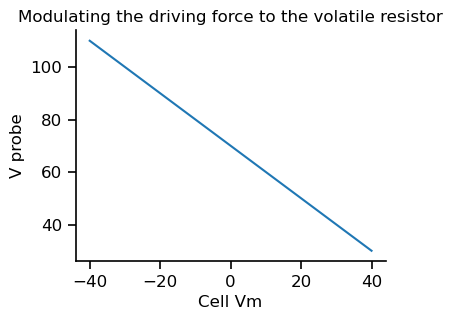

In [185]:
# Define variable probe voltage 

def compute_probeV(V_cell):
    '''Synapse driving force, computed as a function of the cell membrane potential (Vm)'''
    E_rev = 70           # (mV) Reversal potential
    V_probe = E_rev - V_cell # (mV) Driving force
    return V_probe
   
# Plot probeV function
fig,ax = plt.subplots(figsize=[4,3])
V_cell = np.linspace(-40,40,100)
ax.plot(V_cell, compute_probeV(V_cell))
ax.set_xlabel('Cell Vm')
ax.set_ylabel("V probe")
# ax.plot([0,0],[30,110],'--',color=[.8,.8,.8])
# ax.plot([-40,40],[0,0],'--',color=[.8,.8,.8])
ax.set_title('Modulating the driving force to the volatile resistor',fontsize=12)
plt.show()

In [11]:
# Run hardware simulation with voltage-dependent V_probe 

def run_simulation(synapse_range, tau_ampa, tau_nmda):
    first_stim_time = 50.  #ms
    delta_stim = 1. #ms
    end_time = 200. #ms
    stim_timesteps = np.arange(first_stim_time, first_stim_time+delta_stim*synapse_range, delta_stim) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    controlV_dur = 0.4 //dt #ms

    # Neuron model parameters
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    V_cell = 0
    VO2_ampa = Volatile_Resistor(dt)
    baselineV_ampa = VO2_ampa.compute_controlV(tau_ampa)
    baselineV_nmda = VO2_ampa.compute_controlV(tau_nmda)

#     weights = np.random.uniform(0.2,5.,synapse_range)    
    weights_ampa = np.ones(synapse_range)*4
    weights_nmda = np.ones(synapse_range)*8
    
    simulation_results = {'single_EPSPs':[np.ones(len(time))*V_cell],
                          'V':[], 'I_total':[], 'I_ampa':[], 'I_nmda':[],
                          'V_probe':[], 'controlV_ampa':[], 'controlV_nmda':[], 
                          'g_ampa':[], 'g_nmda':[]}    

    # Simulate single EPSPs
    for synapse_id in range(synapse_range):
        VO2_ampa = Volatile_Resistor(dt)
        VO2_nmda = Volatile_Resistor(dt)
        V = np.ones(len(time)) * V_cell
        this_stim_time = stim_timesteps[synapse_id]
        stim_time_extended = np.arange(this_stim_time,this_stim_time+controlV_dur)
        
        for t in range(len(time)): 
            if t > first_stim_time and t not in stim_time_extended:
                VO2_ampa.controlV = baselineV_ampa
                VO2_nmda.controlV = baselineV_nmda
            if t == this_stim_time:
                VO2_ampa.controlV = VO2_ampa.inv_transfer_func(weights_ampa[synapse_id])
                VO2_nmda.controlV = VO2_nmda.inv_transfer_func(weights_nmda[synapse_id])
            V_probe = compute_probeV(V[t])
            I_ampa = VO2_ampa.g * V_probe *1e-3 #currents converted from pA to nA
            I_nmda = VO2_nmda.g * V_probe * nmda_sigmoid(V[t]-70) *1e-3 #currents converted from pA to nA
            I = I_ampa + I_nmda
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((V_cell-V[t]) + I*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
            VO2_ampa.time_step()
            VO2_nmda.time_step()
        simulation_results['single_EPSPs'].append(V)
    
    # Simulate combined EPSPs
    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        VO2_ampa = Volatile_Resistor(dt)
        VO2_nmda = Volatile_Resistor(dt)
        V = np.ones(len(time)) * V_cell
        I = np.zeros(len(time))
        I_ampa = np.zeros(len(time))
        I_nmda = np.zeros(len(time))
        V_probe = np.zeros(len(time)) 
        
        stim_timesteps_sub = stim_timesteps[0:num_synapses]        
        stim_timesteps_extended = np.repeat(stim_timesteps_sub,controlV_dur) + np.tile(np.arange(controlV_dur),len(stim_timesteps_sub))

        for t in range(len(time)): 
            if t > first_stim_time and t not in stim_timesteps_extended:
                VO2_ampa.controlV = baselineV_ampa
                VO2_nmda.controlV = baselineV_nmda
            if t in stim_timesteps_sub:
                active_synapse_ids = np.where(stim_timesteps_sub==t)[0]                
                VO2_ampa.controlV = VO2_ampa.inv_transfer_func(VO2_ampa.g + np.sum(weights_ampa[active_synapse_ids]))
                VO2_nmda.controlV = VO2_nmda.inv_transfer_func(VO2_nmda.g + np.sum(weights_nmda[active_synapse_ids]))

            V_probe[t] = compute_probeV(V[t])
            I_ampa[t] = VO2_ampa.g * V_probe[t] *1e-3 #currents converted from pA to nA
            I_nmda[t] = VO2_nmda.g * V_probe[t] * nmda_sigmoid(V[t]-70) *1e-3 #currents converted from pA to nA
            I[t] = I_nmda[t] + I_ampa[t]
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((V_cell-V[t]) + I[t]*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
            VO2_ampa.time_step()
            VO2_nmda.time_step()

        simulation_results['V'].append(V)
        simulation_results['I_total'].append(I)
        simulation_results['I_ampa'].append(I_ampa)
        simulation_results['I_nmda'].append(I_nmda)
        simulation_results['V_probe'].append(V_probe)
        simulation_results['g_ampa'].append(VO2_ampa.g_history)
        simulation_results['g_nmda'].append(VO2_nmda.g_history)
        simulation_results['controlV_ampa'].append(VO2_ampa.controlV_history)
        simulation_results['controlV_nmda'].append(VO2_nmda.controlV_history)
    simulation_results['stim_times'] = stim_timesteps

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
        
    print(f"Pulse controlV = {pulseV}")
    print(f"Baseline controlV = {baselineV}")
    print(f"Tau = {round(g_volatile.tau(baselineV))} ms")
    return simulation_results

synapse_range = 8
simulation_results = run_simulation(synapse_range, tau_ampa=2, tau_nmda=80)

Pulse controlV = 1.0
Baseline controlV = 0.001910050251256282
Tau = 20 ms


If synaptic driving force is voltage-dependent, the voltage steps get smaller with each successive synapse, 
resulting in strongly sub-linear summation of the individual potentials


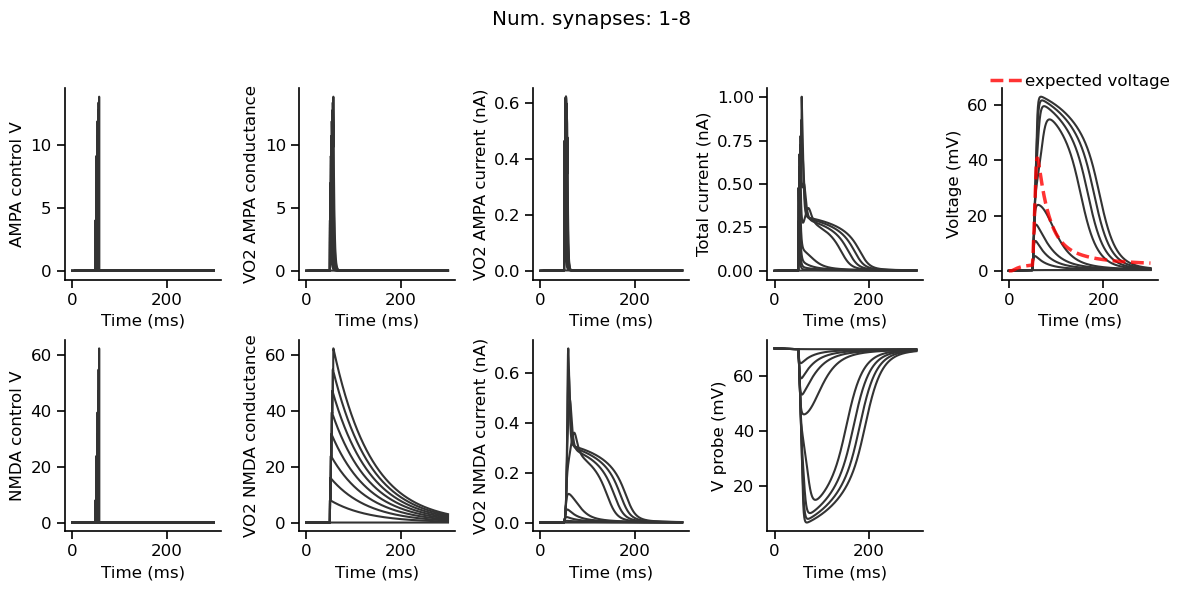

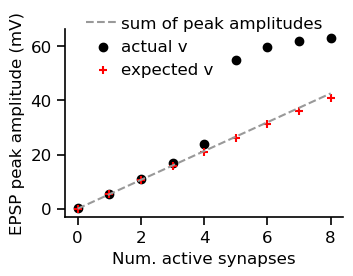

In [12]:
# Plot simulation results 

fig,ax = plt.subplots(2,5,figsize=(12,6))
titles = {'V': 'Voltage (mV)', 'I_total': 'Total current (nA)', 'V_probe': 'V probe (mV)', 
          'controlV_ampa': 'AMPA control V', 'controlV_nmda': 'NMDA control V',
          'I_ampa': 'VO2 AMPA current (nA)', 'I_nmda': 'VO2 NMDA current (nA)', 
          'g_ampa': 'VO2 AMPA conductance',  'g_nmda': 'VO2 NMDA conductance'}

line_color = [0.2,0.2,0.2]

col=0
ax[0,col].plot(time, simulation_results['controlV_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['controlV_ampa'])

ax[1,col].plot(time, simulation_results['controlV_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['controlV_nmda'])
col+=1

ax[0,col].plot(time, simulation_results['g_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['g_ampa'])

ax[1,col].plot(time, simulation_results['g_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['g_nmda'])
col+=1

ax[0,col].plot(time, simulation_results['I_ampa'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['I_ampa'])

ax[1,col].plot(time, simulation_results['I_nmda'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['I_nmda'])
col+=1

ax[1,col].plot(time, simulation_results['V_probe'], c=line_color)
ax[1,col].set_xlabel('Time (ms)')
ax[1,col].set_ylabel(titles['V_probe'])

ax[0,col].plot(time, simulation_results['I_total'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['I_total'])
col+=1

ax[0,col].plot(time, simulation_results['V'], c=line_color)
ax[0,col].set_xlabel('Time (ms)')
ax[0,col].set_ylabel(titles['V'])

baselines = simulation_results['single_EPSPs'][0,:]
summed_EPSP_trace = np.sum(simulation_results['single_EPSPs']-baselines,axis=1) + baselines[0]
ax[0,col].plot(time,summed_EPSP_trace,'--',linewidth=2.5,alpha=0.8,color='r', label='expected voltage')
ax[0,col].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

ax[1,col].axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')


singleEPSP_amplitudes = np.max(simulation_results['single_EPSPs'],axis=0) - baselines
linear_sum = np.cumsum(singleEPSP_amplitudes)
expected_amplitudes = np.max(np.cumsum(simulation_results['single_EPSPs']-baselines,axis=1),axis=0)
multiEPSP_amplitudes = np.max(simulation_results['V'],axis=0) - baselines
num_EPSPs = len(multiEPSP_amplitudes)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6], label='sum of peak amplitudes')
ax.scatter(np.arange(num_EPSPs), multiEPSP_amplitudes, color='k', label='actual v')
ax.scatter(np.arange(num_EPSPs), expected_amplitudes, marker='+',color='r',label='expected v')
ax.set_ylabel('EPSP peak amplitude (mV)')
ax.set_xlabel('Num. active synapses')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))


plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)

print('If synaptic driving force is voltage-dependent, the voltage steps get smaller with each successive synapse, \nresulting in strongly sub-linear summation of the individual potentials')

plt.show()